# Create graph from n-triple file:

In [1]:
import rdflib
from rdflib import Graph
import logging
import os
from IPython.display import clear_output
import random

data_loc = './Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_stripped.nt'
mini_loc = './Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_stripped_mini.nt'
test_loc = "./Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_test_set.nt"
folder = './Downloads/ml4g'
subsample_chance = 1
def create_mini_nt(infile, outfile):
    with open(infile, 'r', encoding='utf-8') as inp, open(outfile, 'w', encoding='utf-8') as out:
        for i, line in enumerate(inp):
            if random.random() <= subsample_chance:
                out.write(line)



def create_new_graph(path, batch_size = 10000, test=True):
    """
    Reads .nt file to produce rdflib graph object containing all tuples.
    """
    logging.basicConfig(
    filename='rdf_parsing_errors.log',
    filemode='w')
    
    graph = Graph()
    batch_num = 0
    i = 0
    with open(path, 'r', encoding='utf-8') as f:
        while True:
            batch = []
            try:
                
                [batch.append(next(f)) for j in range(batch_size)]
                i += j
            except:
                pass
            if not batch:
                break
            batch_num += 1
            nt_string = ''.join(batch)
            try:
                graph.parse(data=nt_string, format='nt')
                if test:
                    graph = Graph()
            except ParseError as e:
                logging.error(f"in batch: {batch_num}:\npproblematic data:\n\n{batch}\n\n")
                check(batch, batch_num, test=test)

    return graph

def check(batch, batch_num, test = True):
    graph = Graph()
    for i, line in enumerate(batch):
        try:
            graph.parse(line)
        except Exception as e:
            logging.error(f'in line: {i}:\n{line}\n{e}')

def to_connected_small(g,subsample_chance=0.8, barrier=100,max_len=5000, verbose=True, save=True):
    """
    Creates a small graph for development.
    Uses similar logic to create_small_graphs()
    """
    obj_set = set()
    mini_graph = Graph()
    i=0
    j=0
    for s,p,o in g:
        if j > max_len:
            break
        i+=1
        if random.random() >= subsample_chance and (i<barrier or s in obj_set or o in obj_set):
            obj_set.add(s)
            obj_set.add(o)
            j+=1
            mini_graph.add(triple=(s,p,o))
    print(f"{i}-->{j}") if verbose else 0
    return mini_graph
# graph = to_connected_small(g)

# g=create_new_graph(data_loc, test=False)


## to create a random subsample of the full graph run:

In [2]:
%%capture
import pickle
import os
import rdflib
import logging
folder = './Downloads/ml4g'

pickle_file_path = os.path.join(folder, 'rdf_graph.pkl')

with open(pickle_file_path, 'rb') as f:
    graph = pickle.load(f)

graph = to_connected_small(graph, max_len=4000)


## to reproduce the experiment instead, run:

In [ ]:
import pickle
import os
import rdflib
import logging
folder = './Downloads/ml4g'

pickle_file_path = os.path.join(folder, 'reproduction_stripped_graph.pkl')

with open(pickle_file_path, 'rb') as f:
    graph = pickle.load(f)

graph = to_connected_small(graph, max_len=4000)

### grab or load train, test, val graphs

In [3]:
import pickle 
# with open('graph_test.pkl', 'wb' ) as f:
#     pickle.dump(graph_test,f)

with open('reproduction_stripped_graph.pkl', 'wb' ) as f:
    pickle.dump(graph,f)

# with open('graph_train.pkl', 'wb' ) as f:
#     pickle.dump(graph_train,f)

# with open('graph_val.pkl', 'wb' ) as f:
#     pickle.dump(graph_val,f)

In [26]:

from typing import defaultdict
test_label_set = set()
train_label_set = set()
val_label_set = set()


test_node_label_map = defaultdict(list)
train_node_label_map = defaultdict(list)
val_node_label_map = defaultdict(list)


test_loc = "./Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_test_set.nt"
train_loc = "./Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_train_set.nt"
val_loc = "./Downloads/ml4g/dmg/mmkg/dmg/scripts/dmg777k_valid_set.nt"

graph_test = create_new_graph(test_loc, test=False)
graph_train = create_new_graph(train_loc, test=False)
graph_val = create_new_graph(val_loc, test=False)

for s,p,o in graph_test:
    test_label_set.add(o.identifier)
    try:
        node_id = inv_node_map[s.identifier]
        test_node_label_map[node_id] = o.identifier
    except: #not everything has to be in node_set with mini graph
        pass
for s,p,o in graph_train:
    train_label_set.add(o.identifier)
    try:
        node_id = inv_node_map[s.identifier]
        train_node_label_map[node_id] = o.identifier
    except: #not everything has to be in node_set with mini graph
        pass

for s,p,o in graph_val:
    val_label_set.add(o.identifier)
    try:
        node_id = inv_node_map[s.identifier]
        val_node_label_map[node_id] = o.identifier
    except: #not everything has to be in node_set with mini graph
        pass

subj_set = set()
for s,p,o in graph_train:
    subj_set.add(s.identifier)

In [5]:
# from rdflib import Graph
# import random
# import pickle
# def create_small_graphs(g,subsample_chance=0.8, barrier=100,max_len=5000, verbose=True, save=True, graph_loc=f'{folder}/graphs/'):
#     """
#     Creates batches to be processed by preprocess().
#     Generator logic is currently unimplemented.
#     """
#     done=False
#     # while not done:
#     obj_set = set()
#     mini_graph = Graph()
#     i=0
#     j=0
#     graph_num=0
#     for s,p,o in g:
#         if j > max_len:
#             graph_name = f'graph_{graph_num}.pkl'
#             if save:
#                 print(f"{i}-->{j}") if verbose else 0
#                 with open(graph_loc+graph_name, 'wb') as f:
#                     pickle.dump(mini_graph, f)
#             mini_graph = Graph()
#             i,j = 0,0
#             graph_num += 1
#         i+=1
#         if random.random() >= subsample_chance and (i<barrier or s in obj_set or o in obj_set):
#             obj_set.add(s)
#             obj_set.add(o)
#             j+=1
#             mini_graph.add(triple=(s,p,o))
        
        
        
#     # return mini_graph
# create_small_graphs(g)

In [6]:
from datetime import datetime
from typing import defaultdict
import torchvision.transforms as trv
import math
import torch
from torch.utils.data import Dataset, DataLoader
from string import printable
import pickle
import base64

def decode_base64_image(encoded_str,log_note='pass values to decode_base_64_jpg'): # - to +, _ to /
        """
        encoded_str: url safe base 64 jpg string --> image bytes string
        """
        try:
            image_bytes = base64.urlsafe_b64decode(encoded_str)
            image_obj = Image.open(BytesIO(image_bytes))
            image = Image.open(BytesIO(image_bytes)).convert('RGB')
            return image, image_obj
        except Exception as e:
            # logging.error(f"{e} error encoding image at {log_note}")
            print(e)
            return None, None

class TextDataset(Dataset):
    def __init__(self, strings, character_map, max_length=5000):
        # self.strings = strings
        self.character_map = character_map
        self.max_length = max_length
        self.strings = strings
        self.ids = []
        self.pad = False
        ids = []
        for string in strings:
            try:
                self.ids.append(inv_node_map[string])
            except KeyError:
                self.ids.append(0) #

    def __len__(self):
        return len(self.strings)

    def __getitem__(self, i, pad=True):
        s = self.strings[i]
        tokens = tokenize_string(s, self.character_map, max_len=self.max_length)

        return torch.tensor([self.ids[i]]+tokens, dtype=torch.long, device=device)


class ImageDataset(Dataset):
    def __init__(self, encoded_images, transform):
        self.encoded_images = encoded_images
        self.transform = transform
        self.ids = [inv_node_map[encoded_image] for encoded_image in encoded_images]

    def __len__(self):
        return len(self.encoded_images)

    def __getitem__(self, i):
        encoded_str = self.encoded_images[i]
        image, _ = decode_base64_image(encoded_str, log_note=f"inside generator, image nr: {i}")
        # print(f"img:{image}")
        if image:
            # print(image)
            image = self.transform(image)
        else:
            # print(image)
            image = torch.zeros(128)
            # image = torch.zeros(3, 224, 224)
        return self.ids[i], image


class NumericalDataset(Dataset):
    def __init__(self, numbers, log_scale=False):
        self.numbers = numbers
        self.log_scale = log_scale
        try:
            self.max_num = max(numbers)
        except:
            self.max_num = 0.1
        self.ids = [inv_node_map[str(number)] for number in numbers]

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, i):
        n = self.numbers[i]
        norm = n / self.max_num
        norm = math.log(norm + 1e-8) if self.log_scale else norm
        return self.ids[i], torch.tensor([norm], dtype=torch.float32, device=device)

class DateTimeDataset(Dataset):
    def __init__(self, dates):
        
        self.dates = dates
        self.ids = [inv_node_map[date] for date in dates]


    def __len__(self):
        return len(self.dates)

    def __getitem__(self, i):
        date = self.dates[i]
        date_feature = encode_date(date)
        return self.ids[i], date_feature




class YearDataset(Dataset):
    def __init__(self, dates):
        
        self.dates = dates
        self.ids = [inv_node_map[date] for date in dates]

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, i):
        date = self.dates[i]
        date_feature = encode_year(date)
        return self.ids[i], date_feature


def process_point(point_str, highest_x, highest_y):
    if 'POINT' in point_str:
        point_str = point_str.split('POINT(')[1].split('))')[0]
    elif 'Point' in point_str:
        point_str = point_str.split('Point(')[1].split('))')[0]
    point_list = point_str.strip(')').strip('(').split()
    point = [float(coord) for coord in point_list]
    point.extend([0,0,0])
    point = tuple(point)
    
    point_x,point_y,_,_,_ = point
    highest_x = point_x if point_x > highest_x else highest_x
    highest_y = point_y if point_y > highest_y else highest_y
    return point, highest_x, highest_y

    
def process_multipoly(multipoly_str, max_x, max_y):
    """
    Delegates polygon processing for multipolygons
    """
    multipoly_str = multipoly_str.split('(((')[-1].split(')))')[0]
    sub_polys = multipoly_str.split(') (')
    multipoly = []
    for i, sub_poly in enumerate(sub_polys):
        aligned_sub_poly = 'POLYGON ((' + sub_poly + '))'
        multipoly.append(get_num_data(aligned_sub_poly, max_x, max_y, last_multi=i==len(sub_polys)))
    return multipoly
        

def get_num_data(poly_str, maximum_x, maximum_y, last_multi=False):
    """
    Processes polygons
    str --> tuples, min/max data
    """
    poly_str = poly_str.split('(')[-1].split(')')[0]
    poly_combi_str_list = [poly for poly in poly_str.split(',')]
    try:
        poly_tupled = [(float(poly.split()[0]),float(poly.split()[1]),1,0,0) if i < len(poly_combi_str_list)-1  else (float(poly.split()[0]),float(poly.split()[1]),0,0,1) if last_multi else (float(poly.split()[0]),float(poly.split()[1]),0,1,0)
                       for i,poly in enumerate(poly_combi_str_list)]
    except ValueError:
        poly_tupled = [(float(poly.strip(')').strip('(').split()[0]),float(poly.strip(')').strip('(').split()[1]),1,0,0) if i < len(poly_combi_str_list)-1  else (float(poly.split()[0]),float(poly.split()[1]),0,0,1) if last_multi else (float(poly.split()[0]),float(poly.split()[1]),0,0,1)
                       for i,poly in enumerate(poly_combi_str_list)]
    x_max, y_max = max([x for x,y,_,_,_ in poly_tupled]), max([y for x, y,_,_,_ in poly_tupled])

    x_max =  x_max if x_max > maximum_x else maximum_x
    y_max =  y_max if y_max > maximum_y else maximum_y
    x_mean = sum([tup[0] for tup in poly_tupled])/len(poly_tupled)
    y_mean = sum([tup[1] for tup in poly_tupled])/len(poly_tupled)
    return poly_tupled, x_mean, y_mean, x_max, y_max

def tokenize_string(s, character_map, max_len=5000):
    s = s[:max_len]
    tokens = [character_map[char] for char in s]
    return tokens #

def encode_image(encoded_str, transform):
    #preprocess for encoder[2](2 layer cnn -->embedding_dim)
    image, img_bytes = decode_base64_image(encoded_str)
    return transform(image), img_bytes

def encode_num(n, max_num, log=False):
    v = n/max_num
    v = math.log(v) if log else v
    return torch.tensor((v),dtype=torch.float32, device=device)

def encode_polygon(poly, global_mean_x, global_mean_y, x_max, y_max):
    poly_tensor_x = (global_mean_x-torch.tensor([ point[0] for point in poly], 
                                                dtype=torch.float32, device=device))/x_max
    poly_tensor_y = (global_mean_y-torch.tensor([ point[1] for point in poly], 
                                                dtype=torch.float32, device=device))/y_max
    return torch.stack((poly_tensor_x,poly_tensor_y),dim=0)

def encode_point(point, max_x, max_y):
    
    point = torch.tensor(point,dtype=torch.float32, device=device)
    div = torch.tensor((max_x,max_y),dtype=torch.float32, device=device)
    return point/div

def encode_date(date):
    def cyclical(num, max_num, epsilon = 1e-8):
        # cyclical: [sine((2pi * X)/max_num_of_cycle) cos((2pi * X)/max_num_of_cycle)]
        return torch.tensor([math.sin((2 * math.pi * num)/max_num)+epsilon, 
                             math.cos((2 * math.pi * num)/max_num)+epsilon],
                            dtype=torch.float32, device=device)
    def norm_cent(num):
        # non-cyclical only centuries: normalized from -99 to 99 (-9999 bc to 9999 ac)
        return torch.tensor((num + 99)/198,dtype=torch.float32, device=device).unsqueeze(0)
        
    split_str = date.split('-')
    years_str = split_str[0]
    month_str = split_str[1]
    day_str = split_str[2]
    centuries = norm_cent(int(years_str[:-2]))
    decades = cyclical(int(years_str[-2]), 10)
    years = cyclical(int(years_str[-1]), 10)
    months = cyclical(int(month_str), 12)
    days = cyclical(int(day_str), 31)
    return torch.cat((centuries, decades, years, months, days), dim=0)

def encode_year(year):
    #preprocess for temporal encoder[4](? layer ffnn -->embedding_dim)
    def cyclical(num, max_num, epsilon = 1e-8):
        # cyclical: [sine((2pi * X)/max_num_of_cycle) cos((2pi * X)/max_num_of_cycle)]
        return torch.tensor([math.sin((2 * math.pi * num)/max_num)+epsilon, 
                             math.cos((2 * math.pi * num)/max_num)+epsilon],
                            dtype=torch.float32, device=device)
        
    def norm_cent(num):
        # non-cyclical only centuries: normalized from -99 to 99 (-9999 bc to 9999 ac)
        return torch.tensor((num + 99)/198,dtype=torch.float32, device=device).unsqueeze(0)
    years_str = year
    centuries = norm_cent(int(years_str[:-2]))
    decades = cyclical(int(years_str[-2]), 10)
    years = cyclical(int(years_str[-1]), 10)
    return torch.cat((centuries, decades, years), dim=0)


class SpatialDataset(Dataset):
    def __init__(self, spatial_data, global_mean_x, global_mean_y, x_max, y_max, ids):
        self.spatial_data = spatial_data
        self.global_mean_x = global_mean_x
        self.global_mean_y = global_mean_y
        self.x_max = x_max
        self.y_max = y_max
        try:
            self.max_len = max([len(data) for data in spatial_data])
        except:
            self.max_len = 0
        self.ids = ids#[inv_node_map[spatial_datum] for spatial_datum in spatial_data]

    def __len__(self):
        return len(self.spatial_data)

    def __getitem__(self, i):
        spatial = self.spatial_data[i]
        spatial_tensors = []
        if isinstance(spatial, list):
            for x,y,a,b,c in spatial:
                
                x = (x - self.global_mean_x) / self.x_max
                y = (y - self.global_mean_y) / self.y_max
                coord_tensor = torch.tensor([x,y,a,b,c], device=device)
                spatial_tensors.append(coord_tensor)
            spatial_tensor = torch.stack(spatial_tensors,dim=0)
        elif isinstance(spatial, tuple):
            x, y,_,_,_ = spatial
            spatial_tensor = torch.tensor([(x / self.x_max, y / self.y_max,0,0,0)], dtype=torch.float32, device=device)
        else:
            spatial_tensor = torch.zeros((1, 2), dtype=torch.float32, device=device)
        return self.ids[i], spatial_tensor

    

    
    def save_bytes_to_jpg(image_bytes, item_num=0,folder='Downloads/ml4g/image_data/',name='Fred'):
        filename = f'{folder}{name}_{item_num}.jpg'
        with open(filename, 'wb') as img_file:
            img_file.write(image_bytes)
        
        class DateTimeDataset(Dataset):
            def __init__(self, dates):
                
                self.dates = dates
                self.ids = [inv_node_map[date] for date in dates]
    
    
        def __len__(self):
            return len(self.dates)
    
        def __getitem__(self, i):
            date = self.dates[i]
            date_feature = encode_date(date)
            return self.ids[i], date_feature
    

In [7]:
from PIL import Image
from io import BytesIO

def preprocess(graph):
    """
    graph --> datasets
    """
    global inv_node_map 
    global node_map
    global edge_map
    global inv_edge_map
    global device
    global img_list
    global transform_temp
    
    
    node_set = set()
    http_set_s = set()
    http_set_m = set()
    http_set_l = set()
    
    edge_set = set()
    string_set_s = set()
    string_set_m = set()
    string_set_l = set()
    
    image_set = set()
    num_set = set()
    poly_set = set()
    datetime_set = set()
    date_set = set()
    year_set = set()
    point_set = set()
    
    text_edge_set_s = set()
    text_edge_set_m = set()
    text_edge_set_l = set()
    
    image_edge_set = set()
    num_edge_set = set()
    spatial_edge_set = set()
    temporal_edge_set = set()
    encoder_map = defaultdict(list)
    
    i = 0
    
    dtype_set = set()
    def is_date(date_string):
        try:
            rdflib.term.parse_datetime(date_string)
            return 'datetime'
        except ValueError:
            try:
                rdflib.term.parse_xsd_gyear(date_string)
                return 'year'
            except:
                try:
                    rdflib.term.parse_xsd_date(date_string)
                    return 'date'
                except:
                    return False

    def add_str_to_set(string,edge):
        if len(string) < 20:
            string_set_s.add(string)
            text_edge_set_s.add(edge)
        elif len(string) < 50:
            string_set_m.add(string)
            text_edge_set_m.add(edge)
        else:
            string_set_l.add(string)
            text_edge_set_l.add(edge)
    
    
    for s,p,o in graph:
        i+=1
        pi = p.identifier
        if s.identifier in subj_set:
            pass
        for node in [s,o]:
            ni = node.identifier
            node_set.add(ni)
            try:
                dtype = node.datatype.identifier
                dtype_set.add(dtype)
            except AttributeError:
                dtype = ''
            if 'http' in ni[:200]: #200, because images sometimes have kgbench url attached
                if len(ni) < 20:
                    http_set_s.add(''.join(ni.split(':')[1].split('/')[:-1]))
                elif len(ni) < 50:
                    http_set_m.add(''.join(ni.split(':')[1].split('/')[:-1]))
                else:
                    http_set_l.add(''.join(ni.split(':')[1].split('/')[:-1]))
    
            else:
                if is_date(ni) and ('Year' in dtype or 'date' in dtype):
                    date_type = is_date(ni)
                    if date_type == 'datetime':
                        datetime_set.add(ni)
                    elif date_type == 'year':
                        year_set.add(ni)
                    elif date_type == 'date':
                        date_set.add(ni)
                        
                elif node.isalnum():
                    if node.isnumeric():
                        if node.isdigit():
                            num_set.add(int(node.identifier))
                            num_edge_set.add(pi)
                        else:
                            num_set.add(float(node.identifier))
                elif ni.startswith('POINT') or ni.startswith('Point'): #didn't see any points, but according to the paper they can be included.
                    point_set.add(ni)
                    spatial_edge_set.add(pi)
                elif node.isalpha():
                   add_str_to_set(ni, pi)
                   image_set.add(ni)
                elif ni.startswith('_9j_'):
                    image_set.add(ni) #might want to load this to hard drive if memory becomes an issue.
                    image_edge_set.add(pi)
                elif ni.startswith('POLYGON') or ni.startswith('Polygon'):
                    poly_set.add(ni)
                    spatial_edge_set.add(pi)                
                    temporal_edge_set.add(pi)
                elif ni.lower().startswith('multipolygon'):
                    poly_set.add(ni)
                elif ni.isascii():
                    add_str_to_set(ni,pi)
                elif ni.isprintable():
                    add_str_to_set(ascii(ni),pi) #don't know if it's necessary, but it probably can't hurt
                else:
                    add_str_to_set(ascii(ni),pi)
    
                    
    
        edge_set.add(pi)

    
    transform_temp = trv.Compose([
        trv.Resize((224, 224)),
        trv.ToTensor(), trv.Normalize(
            mean=[0.5, 0.5, 0.5], 
            std=[0.3, 0.3, 0.3])]) 
    

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    node_map = {i:node for i,node in enumerate(node_set)}
    inv_node_map = {node:i for i,node in enumerate(node_set)}
    
    edge_map = {i:edge for i,edge in enumerate(edge_set)}
    inv_edge_map = {edge:i for i,edge in enumerate(edge_set)}

    
    global_mean_x = 0
    global_mean_y = 0
    
    max_x = 0
    max_y = 0
    
    
    points_tupled = []
    point_ids = []
    for i, point in enumerate(point_set):
        point_tupled,max_x,max_y = process_point(point,max_x,max_y)
        points_tupled.append(point_tupled)
        point_ids.append(inv_node_map[point])
    
    
    polys_tupled = []
    poly_ids = []
    x_max, y_max = 0,0
    done = False
    multipolys_tupled = []
    for i, poly in enumerate(poly_set):
        if 'multi' in poly.lower():
            multipolys_tupled.append(process_multipoly(poly, x_max, y_max))
            
        poly_tupled, x_mean, y_mean, x_max, y_max = get_num_data(poly, 
                                                                 x_max, y_max)
        global_mean_x += 1
        global_mean_y += 1
        polys_tupled.append(poly_tupled)
        poly_ids.append(inv_node_map[poly])
    i += 1
    global_mean_x, global_mean_y = global_mean_x/i, global_mean_y/i
    
    
    character_map = {char:i for i,char in enumerate(printable)}
    character_map['\x7f'] = 101
    
    text_dataset_s = TextDataset(list(string_set_s), character_map)
    text_dataset_m = TextDataset(list(string_set_m), character_map)
    text_dataset_l = TextDataset(list(string_set_l), character_map)

    img_list = list(image_set)
    image_dataset = ImageDataset(img_list, transform_temp)
    numerical_dataset = NumericalDataset(list(num_set), log_scale=True)
    
    spatial_dataset = SpatialDataset(polys_tupled + points_tupled, global_mean_x, global_mean_y, x_max, y_max, ids=point_ids + poly_ids)
    
    datetime_dataset = DateTimeDataset(list(datetime_set))
    year_dataset = YearDataset(list(year_set))
    return text_dataset_s, text_dataset_m, text_dataset_l, image_dataset , numerical_dataset, spatial_dataset, datetime_dataset, year_dataset, node_map, edge_map, inv_node_map, inv_edge_map
        
text_dataset_s, text_dataset_m, text_dataset_l, image_dataset , numerical_dataset, spatial_dataset, datetime_dataset, year_dataset,node_map, edge_map, inv_node_map, inv_edge_map = preprocess(graph)            


/home/royal-cookings/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Convert raw values to consistent feature vectors for the encoders:

In [8]:
from torch.utils.data import DataLoader

def collate_spatial(batch):
    nodes_ids, batch = zip(*batch)
    padded = nn.utils.rnn.pad_sequence(batch, batch_first=True)
    padded = padded.permute(0, 2, 1)
    return nodes_ids, padded

def collate_text(batch, min_size=20):
    if batch[0].size(0) < min_size:
        pad_num = min_size - batch[0].size(0)
        pads = torch.zeros(pad_num, dtype=torch.long, device=device)
        batch[0] = torch.cat([batch[0], pads], dim=0)
    return nn.utils.rnn.pad_sequence(batch, batch_first=True)

batch_size = 32

spatial_dataloader = DataLoader(spatial_dataset, batch_size=batch_size, collate_fn=collate_spatial)
text_dataloader_s = DataLoader(text_dataset_s, batch_size=batch_size, collate_fn=collate_text)
text_dataloader_m = DataLoader(text_dataset_m, batch_size=batch_size, collate_fn=collate_text)
text_dataloader_l = DataLoader(text_dataset_l, batch_size=2, collate_fn=collate_text) #it crashes every time it starts :'(
image_dataloader = DataLoader(image_dataset, batch_size=2)
datetime_dataloader = DataLoader(datetime_dataset, batch_size=batch_size)
year_dataloader = DataLoader(year_dataset, batch_size=batch_size)
numerical_dataloader = DataLoader(numerical_dataset, batch_size=batch_size)

# Multimodal Encoders

In [9]:
import torch.functional as f
import torch.nn as nn

# ]1] temporal conv
# Layer Filters Kernel Padding Pool
# 1 64 7 3 max(2/2)
# 2 64 7 3 max(2/2)
# 3 64 7 3 -
# 4 64 7 2 max(·)
# Layer Dimensions
# 5 512
# 6 128
# 7 128
class TextEncoder(nn.Module):
    def __init__(self, embed_dim, vocab_size=102, dropout=0.4, size_type='medium'): #filters = 64
        super(TextEncoder, self).__init__()
        self.size_type = size_type.lower()
        self.mlp_hidden_dim = 1024 if self.size_type == 'large' else 512 if self.size_type == 'medium' else 256
        self.tcnn_hidden_dim = 128 if self.size_type == 'large' else 64 if self.size_type == 'medium' else 32
        self.dilation_vals = (1,1,1) if self.size_type == 'small' else (2,4,8)

        
        self.embedding = nn.Embedding(vocab_size, embed_dim) #used embedding dict instead of ohe to save space
                                                            #sparse should probably work too
        self.conv1 = nn.Conv1d(
            embed_dim, self.tcnn_hidden_dim , kernel_size=7, padding=3, dilation=1)
        
        self.norm1 = nn.BatchNorm1d(self.tcnn_hidden_dim )
        self.drop1 = nn.Dropout(dropout)
        self.pool1 = nn.MaxPool1d(2,2)
        self.conv2 = nn.Conv1d(
            self.tcnn_hidden_dim , self.tcnn_hidden_dim , kernel_size=7, padding=3)

        self.norm2 = nn.BatchNorm1d(self.tcnn_hidden_dim )
        self.drop2 = nn.Dropout(dropout)
        self.pool2 = nn.MaxPool1d(2,2)
        self.conv3 = nn.Conv1d(
            self.tcnn_hidden_dim , self.tcnn_hidden_dim , kernel_size=7, padding=3)

        self.norm3 = nn.BatchNorm1d(self.tcnn_hidden_dim )
        self.drop3 = nn.Dropout(dropout)
        self.conv4 = nn.Conv1d(
            self.tcnn_hidden_dim , self.tcnn_hidden_dim , kernel_size=7, padding=2)#, dilation=self.dilation_vals[2])
        
        self.norm4 = nn.BatchNorm1d(self.tcnn_hidden_dim )
        self.drop4 = nn.Dropout(dropout)
        self.pool4 = nn.AdaptiveMaxPool1d(1)

        self.lin1 = nn.Linear(self.tcnn_hidden_dim, self.mlp_hidden_dim)
        self.lin2 = nn.Linear(self.mlp_hidden_dim, embed_dim)
        self.lin3 = nn.Linear(embed_dim , embed_dim)
        
        self.act = nn.ReLU()

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        residual = embedded
        #conv
        
        x = self.conv1(embedded)
        x = self.norm1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.act(x)
        x = self.drop3(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.act(x)
        x = self.drop4(x)
        # if residual.size(1) != x.size(1):
        #   residual = nn.utils.rnn.pad_sequence([residual, x], batch_first=True)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        #ffnn
        x = self.lin1(x)
        x = self.lin2(x)
        # x += residual
        x = self.lin3(x)
        
        
            
        return x


# [2] MobileNet 
# Type / Stride Filter Shape Input Size
# Conv / s2 3 × 3 × 3 × 32 224 × 224 × 3
# Conv dw / s1 3 × 3 × 32 dw 112 × 112 × 32
# Conv / s1 1 × 1 × 32 × 64 112 × 112 × 32
# Conv dw / s2 3 × 3 × 64 dw 112 × 112 × 64
# Conv / s1 1 × 1 × 64 × 128 56 × 56 × 64
# Conv dw / s1 3 × 3 × 128 dw 56 × 56 × 128
# Conv / s1 1 × 1 × 128 × 128 56 × 56 × 128
# Conv dw / s2 3 × 3 × 128 dw 56 × 56 × 128
# Conv / s1 1 × 1 × 128 × 256 28 × 28 × 128
# Conv dw / s1 3 × 3 × 256 dw 28 × 28 × 256
# Conv / s1 1 × 1 × 256 × 256 28 × 28 × 256
# Conv dw / s2 3 × 3 × 256 dw 28 × 28 × 256
# Conv / s1 1 × 1 × 256 × 512 14 × 14 × 256
# 5×
# Conv dw / s1 3 × 3 × 512 dw 14 × 14 × 512
# Conv / s1 1 × 1 × 512 × 512 14 × 14 × 512
# Conv dw / s2 3 × 3 × 512 dw 14 × 14 × 512
# Conv / s1 1 × 1 × 512 × 1024 7 × 7 × 512
# Conv dw / s2 3 × 3 × 1024 dw 7 × 7 × 1024
# Conv / s1 1 × 1 × 1024 × 1024 7 × 7 × 1024
# Avg Pool / s1 Pool 7 × 7 7 × 7 × 1024
# FC / s1 1024 × 1000 1 × 1 × 1024
# Softmax / s1 Classifier 1 × 1 × 1000
# Table 2. Resource Per Layer Type
# Type Mult-Adds Parameters
# Conv 1 × 1 94.86% 74.59%
# Conv DW 3 × 3 3.06% 1.06%
# Conv 3 × 3 1.19% 0.02%
# Fully Connected 0.18% 24.33%

#idea: pass identity vector with batches to encoders (don't process, just pass back), use that to map embeddings to nodes later
class ImageEncoder(nn.Sequential):
    def __init__(self, embed_dim):
        super(ImageEncoder, self).__init__()
        

        self.image = MobileBlock(3, 32, normal_conv=True, stride=1, alpha=0.5)
        self.image2 = MobileBlock(32, 64, stride=1, alpha=0.5)
        self.image3 = MobileBlock(64, 128, stride=2, alpha=0.5)
        self.image4 = MobileBlock(128, 256, stride=1, alpha=0.5)
        self.image5 = MobileBlock(256, 256, stride=2, alpha=0.5)
        self.image6 = MobileBlock(256, 512, stride=1, alpha=0.5)
        self.image7 = MobileBlock(512, 512, stride=2, alpha=0.5)
        self.image8 = MobileBlock(512, 1024, stride=1, alpha=0.5)
        self.middle_conv = nn.Sequential(*[MobileBlock(
                1024, 1024, stride=1, alpha=0.5) for i in range(5)])
        
        self.image9 = MobileBlock(1024, 1024, stride=1, alpha=0.5)
        
        self.image10 = MobileBlock(1024, 2048, stride=2, alpha=0.5)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lin1 = nn.Linear(1024,embed_dim)
        self.norm = nn.BatchNorm1d(embed_dim)
        self.act = nn.ReLU()
        # middle_conv = [MobileBlock() for i in range(5)]


    def forward(self, batch):
        x = self.image(batch)
        x = self.image2(x)
        x = self.image3(x)
        x = self.image4(x)
        x = self.image5(x)
        x = self.image6(x)
        x = self.image7(x)
        x = self.image8(x)
        x = self.middle_conv(x)
        x = self.image9(x)
        x = self.image10(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        # x = self.norm(x) #batch size is too small on my system due to computational constraints
        x = self.act(x)
        return x

class MiniImgEnc(nn.Sequential):
    def __init__(self, embed_dim):
        super(MiniImgEnc, self).__init__()
        self.image = MobileBlock(3, 32, normal_conv=True, stride=1, alpha=0.5)
        self.image2 = MobileBlock(32, 64, stride=1, alpha=0.5)
        self.image3 = MobileBlock(64, 128, stride=2, alpha=0.5)
        self.image4 = MobileBlock(128, 256, stride=1, alpha=0.5)
        self.image5 = MobileBlock(256, 512, stride=2, alpha=0.5)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lin1 = nn.Linear(256,embed_dim)
        self.norm = nn.BatchNorm1d(embed_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.image(x)
        x = self.image2(x)
        x = self.image3(x)
        x = self.image4(x)
        x = self.image5(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        # x = self.lin2(x)
        # x = self.norm(x)
        return self.act(x)
        

        

class MobileBlock(nn.Module):
    def __init__(self, in_channels, embedding_size, stride=1, normal_conv=False, alpha=0.5, dilation=1):
        super(MobileBlock, self).__init__()
        old_in_channels = in_channels
        in_channels = int(alpha * in_channels)
        embedding_size = int(alpha * embedding_size)
        # depthwise conv
        self.normal_conv = normal_conv
        if self.normal_conv:
            # in_channels = in_channels//2
            pass
        # 3x3x3x32
        self.conv = nn.Conv2d(old_in_channels, in_channels, 3, padding=1, stride=2, dilation=1)
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, stride=stride,
                                   padding=1, groups=in_channels)
        self.norm1 = nn.BatchNorm2d(in_channels)
        
        # pointwise conv
        self.pointwise = nn.Conv2d(in_channels, embedding_size, 1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(embedding_size)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        if self.normal_conv:
            x = self.conv(x)
        x = self.depthwise(x)
        # x = self.norm1(x)
        x = self.act(x)
        
        x = self.pointwise(x)
        # x = self.norm2(x) #normalization disabled due to computational constraints
        return self.act(x)




# [3] temporal conv
# layer filters kernel padding pool
# 1 16 5 2 max(3/3)
# 2 32 5 2 -
# 3 64 5 2 avg(·)
# layer dimensions
# 4 512
# 5 128
# 6 128
class SpatialEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim=128, dropout=0.2):
        super(SpatialEncoder, self).__init__()
        
        # temp cnn
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3, ceil_mode=True)
        self.norm1 = nn.BatchNorm1d(16)
        self.drop1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.norm2 = nn.BatchNorm1d(32)
        self.drop2 = nn.Dropout(dropout)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        self.norm3 = nn.BatchNorm1d(64)
        self.drop3 = nn.Dropout(dropout)
        
        # dense
        self.lin1 = nn.Linear(64, 512)
        self.lin2 = nn.Linear(512, 128)
        self.lin3 = nn.Linear(128, embed_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, spatial):
        # x = self.pad(spatial, batch_first=True)
        x = self.conv1(spatial)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.act(x)
        
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.norm3(x)
        x = self.act(x)
        x = self.drop3(x)
        
        x = x.view(x.size(0), -1) #flatten
        
        x = self.lin1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.lin2(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.lin3(x)
        x = self.act(x)
        x = self.dropout(x)
        return x
        

# [4] mlp h == in dim 1st col, out 2nd col
# XSD:gYear 6 2
# XSD:date 10 4
# XSD:dateTime 14 6
class TemporalEncoder(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(TemporalEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim
        self.out_dim = 2 if input_dim <= 6 else 4 if input_dim <= 9 else 6 #I messed something up but its very specific...
                                                                        #norm_cent returns a digit so idk if that should be 2?
                                                                        #there's no sin/cos, so it seems weird to encode it digitwise
        num_layers = 2
        self.mlp = nn.Sequential(*[nn.Linear(input_dim, input_dim), 
                                   nn.ReLU(),nn.BatchNorm1d(input_dim)]*num_layers)
        self.out = nn.Linear(input_dim, self.out_dim)

    def forward(self, x):
        x = self.mlp(x)
        return self.out(x)
    

#[5] one to one encoding for numerical
class NumericalEncoder(nn.Module):
    def __init__(self):
        super(NumericalEncoder, self).__init__()
        pass
    def forward(self, x):
        return x

# Combined

In [31]:
text_encoder_s, text_encoder_m, text_encoder_l = TextEncoder(128, size_type='s'), TextEncoder(128, size_type='m'), TextEncoder(128, size_type='m')
datetime_encoder = TemporalEncoder(9)
spatial_encoder = SpatialEncoder(5)
year_encoder = TemporalEncoder(5)
image_encoder = ImageEncoder(128)
numerical_encoder = NumericalEncoder()


class MultiModalEncoder(nn.Module):
    def __init__(self,
                 feature_matrix,
                 encoders_config, dropout=False):
        super(MultiModalEncoder, self).__init__()

        # self.dataloaders = [config['dataloader'] for config in encoders_config]
        self.encoders_config = encoders_config
        self.feature_matrix = feature_matrix
        self.column_map = {'text':(0,128),
                           'image':(128,256),
                           'numerical':(256,257),
                           'spatial':(257, 385),
                           'datetime':(385,389),
                           'year':(389,391)}

        self.encoders = nn.ModuleList([config['encoder'] for config in encoders_config])
        self.encoder_dataloaders = [config['dataloader'] for config in encoders_config]
        
        self.x_indices = []#torch.zeros(8, device=device)
        self.y_indices = []
        self.values = []#torch.zeros((8,128), device=device)
        self.dropout = dropout

        self.num_nodes = feature_matrix.size()[0]

    def forward(self):
        embed_dim = self.column_map['year'][-1]
        out_feature_matrix = torch.zeros((self.num_nodes, embed_dim), dtype=torch.float32, device=self.feature_matrix.device)
        for encoder, config in zip(self.encoders,self.encoders_config):
            if random.random()>self.dropout:
                continue
            self.x_indices = []
            self.y_indices = []
            self.values = []
            name = config['name']
            #encoder = #config['encoder'].to(device)
            dataloader = config['dataloader']
            # print(f"encoder: {name}")
            i = 0
            # if 'image' not in name:
            for j, batch in enumerate(dataloader):
                # if random.random()>self.dropout:
                #     x,y = self.column_map[name]
                #     output_dim = y-x
                #     embeddings = torch.zeros(y-x, dtype=torch.float32,device=device).unsqueeze(0)
                #     continue
                    
                if 'text' in name:
                    cols = self.column_map['text']
                    node_ids = batch[:, 0]
                    features = batch[:, 1:]
                else:
                    cols = self.column_map[name]
                    node_ids, features = batch
                    node_ids = torch.tensor(node_ids,device=device)
                    # node_ids = node_ids.clone().detach().to(device)

                # I confused myself. passing the node_ids through the forward pass was completely unnecessary.
                # change to sparse and use automatic column assignment base on thingy
                try:
                    embeddings = encoder(features)
                    # print(f"{name}: {embeddings}")
                except ValueError: #if batch size is 0 or 1 when it's supposed to be more.
                    # print('err')
                    x,y = self.column_map[name]
                    output_dim = y-x
                    embeddings = torch.zeros(y-x, dtype=torch.float32,device=device).unsqueeze(0)

                # batch_size = node_ids.size(0)
                # y_cols = torch.arange(cols[0], cols[1], device=device).unsqueeze(0).repeat(batch_size, 1)
                # embedding_size = embeddings.size(1)
                # x_rows = node_ids.unsqueeze(1).repeat(1, embedding_size)
                # self.x_indices.append(x_rows)
                # self.y_indices.append(y_cols)
                # self.values.append(embeddings.view(-1))
                i+=1

        # else:
        #     for img in dataloader:
        #         pass
                try:
                    # x = torch.cat(self.x_indices).reshape(-1)
                    # y = torch.cat(self.y_indices).reshape(-1)
                    # indices = torch.stack([x, y], dim=0)
                    # values = torch.cat(self.values)
                    # self.feature_matrix = torch.zeros((self.num_nodes, 396), dtype=torch.float32, device=device)
                    # self.feature_matrix.index_put_(indices, values)
                    out_feature_matrix[node_ids, cols[0]:cols[1]] = embeddings
                    torch.cuda.empty_cache()
                except Exception as e:
                    print(e)

        return out_feature_matrix


encoders_config = [{'name': 'text_s', 'encoder': text_encoder_s, 'dataloader': text_dataloader_s},
                   {'name': 'text_m', 'encoder': text_encoder_m, 'dataloader': text_dataloader_m},
                   {'name': 'text_l', 'encoder': text_encoder_l, 'dataloader': text_dataloader_l},
                   {'name': 'image', 'encoder': image_encoder, 'dataloader': image_dataloader},
                   {'name': 'numerical', 'encoder': numerical_encoder, 'dataloader': numerical_dataloader},
                   {'name': 'spatial', 'encoder': spatial_encoder, 'dataloader': spatial_dataloader},
                   {'name': 'datetime', 'encoder': datetime_encoder, 'dataloader': datetime_dataloader},
                   {'name': 'year', 'encoder': year_encoder, 'dataloader': year_dataloader},]


num_nodes = len(node_map)

embed_size = 128 + 128 + 1 + 128 + 4 + 2

feature_matrix = torch.zeros((num_nodes, embed_size), dtype=torch.float32, device='cpu')#.to_sparse()



# multi_modal_encoder = MultiModalEncoder(
#     feature_matrix=feature_matrix,
#     encoders_config=encoders_config, dropout=0.2).to(device)


# feature_matrix = multi_modal_encoder()

In [11]:
num_nodes

3936

# Connect to R-GCN

In [32]:
length = len(node_map.keys())

indices = torch.zeros((1),device=device)
indices = torch.arange(0, length, device=device).repeat(2, 1)

values = torch.ones(length, device=device)
identity = torch.sparse_coo_tensor(indices, values, (length, length), device=device).to_dense()
feature_matrix_cat = torch.cat((identity,feature_matrix),dim=1)

In [33]:
#uncomment for sparse

from typing import defaultdict
# adjacency = defaultdict(torch.sparse_coo_tensor)
graph_size = max(node_map.keys()) +1
adjacency = defaultdict(lambda: torch.zeros((graph_size, graph_size), device=device))


# inv_edge_map
indices_x = defaultdict(list)
indices_y = defaultdict(list)

values = defaultdict(list)
i=0
for s, p, o in graph:
    edge_id = inv_edge_map[p.identifier]
    s_id = inv_node_map[s.identifier]
    o_id = inv_node_map[o.identifier]
    
    # indices_x[edge_id].append(s_id)
    # indices_y[edge_id].append(o_id)
    # values[edge_id].append(1)
    adjacency[edge_id][s_id, o_id] = 1
    i += 1


# for edge_id in indices_x.keys():
#     ind_x, ind_y = torch.tensor(indices_x[edge_id]), torch.tensor(indices_y[edge_id])
#     ind = torch.stack((ind_x, ind_y))
#     val = values[edge_id]
#     adjacency[edge_id] = torch.sparse_coo_tensor(indices=ind,values=val,size=(graph_size,graph_size),device=device)
    
i

4001

In [34]:
#dense
def normalize_adjacency(A, self=True): #gotta still add self-loops. See if it works without first.
    if self:
        A = A + torch.eye(A.size(0), device=device)
    degree = A.sum(dim=1)
    d_inv_sqrt = torch.pow(degree, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    return A * d_inv_sqrt.unsqueeze(1) * d_inv_sqrt.unsqueeze(0)

for i, key in enumerate(adjacency.keys()):
    A = adjacency[key]
    adjacency[key] = normalize_adjacency(A)
    del A
    # print(f'Great success! {i}')
    k = key
adjacency[k]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [35]:
##save non-error version
def block_diag (weights):
    block_diag_matrix = torch.block_diag(*weights)
    return block_diag_matrix
    

class R_GCNLayer(nn.Module):
    def __init__(self, x_dim, y_dim, num_relations, block_split):
        super(R_GCNLayer, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.num_relations = num_relations
        gain = nn.init.calculate_gain('relu')
        max_block_size = 1
        for i in range(1,11):
            if x_dim % i == 0 and y_dim % i == 0:
                max_block_size +=1 
        x_block_size = x_dim // block_split
        y_block_size = y_dim // block_split
        self.W = nn.ParameterList()
        for _ in range(num_relations):
            wr = nn.ParameterList()
            for i in range(block_split):
                w = nn.Parameter(torch.randn(x_block_size, y_block_size)) 
                nn.init.kaiming_uniform_(w, a=gain)
                wr.append(w)
            x_remainder = x_dim % block_split
            y_remainder = y_dim % block_split
            if  x_remainder > 0 and y_remainder > 0:
                w = nn.Parameter(torch.randn(x_remainder, y_remainder)) 
                nn.init.kaiming_uniform_(w, a=gain)
                wr.append(w)
            self.W.append(wr)

        self.bias = nn.Parameter(torch.zeros(y_dim))
        nn.init.zeros_(self.bias)

    

    def forward(self, A, X):
        device = next(self.parameters()).device
        aggregated = torch.zeros((X.size(0), self.y_dim), device=device)
        for r in range(self.num_relations):
            X = X.to_dense()
            if X.is_sparse:
                diag = block_diag(self.W[r]).to_dense()
                correct_indices = (indices >= 0).all(dim=0)
                X = X.coalesce()
                if diag.is_sparse: #this really defeats the point of using sparse matrices, but torch.sparse only supports sparse, dense mm
                    diag = diag.to_dense()
                    
                weighted = torch.matmul(X, diag)
            else:
                weighted = torch.matmul(X, block_diag(self.W[r])) 
            if A[r].is_sparse:
                transformed = torch.matmul(A[r], weighted)
            else:
                transformed = torch.matmul(A[r], weighted)
            aggregated += transformed
        aggregated += self.bias
        return aggregated



class R_GCN(nn.Module):
    def __init__(self, x_dim, h_dim, y_dim, max_k_hop, num_relations):
        super(R_GCN, self).__init__()
        self.max_k_hop =max_k_hop
        self.num_relations = num_relations
        self.x_dim = x_dim
        self.block_split = 1
        self.bases = 1
        self.gcns = nn.ModuleList([R_GCNLayer(x_dim, h_dim, num_relations, self.bases) for _ in range(max_k_hop)])
        # self.gcns = nn.ModuleList([R_GCNLayer(x_dim, h_dim, num_relations) for _ in range(max_k_hop)])
        self.final_r_gcn = R_GCNLayer(h_dim, y_dim,num_relations, self.bases )
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm1d(y_dim)
        self.soft = nn.Softmax()


    
        
    def forward(self, A, X):
        # if X.size(0) % 2 !=0:
        #     X = X[:-1,:]
        # outer layers
        device = next(self.parameters()).device
        for i in range(self.max_k_hop):
            H = self.gcns[i](A, X)
            H = self.act(H)
            H = self.drop(H)
        Y = self.final_r_gcn(A, H)
        out = self.act(Y)
        out = self.norm(out)
        out = self.soft(out)
        return out#nn.LogSoftmax(Y)

#feature_matrix.size(0)+1
num_classes=5
# r_gcn = R_GCN(feature_matrix_cat.size(1), 32, num_classes, max_k_hop=2, num_relations=i+1).to(device)
# out = r_gcn([normalize_adjacency(adjacency[relation_id]) for relation_id in adjacency.keys()], feature_matrix_cat)
# out

In [36]:
class MR_GCN(nn.Module):
    def __init__(self, A_list, eye, num_nodes, rgcn_inp_dim, embed_size=396, num_classes=5, dropout=False):
        super(MR_GCN, self).__init__()
        
        self.A_list = A_list
        self.embed_size = embed_size
        # self.embedding_matrix = torch.zeros((num_nodes, embed_size), dtype=torch.float32, device=device)#.to_sparse()
        self.embedding_matrix = nn.Parameter(torch.zeros((num_nodes, embed_size), dtype=torch.float32, device=device))
        self.MME= MultiModalEncoder(feature_matrix=self.embedding_matrix, encoders_config=encoders_config,dropout=dropout).to(device)
        self.graph_dim = A_list[0].size(0)
        self.R_GCN = R_GCN(rgcn_inp_dim, 128, num_classes, max_k_hop=2, num_relations=len(A_list)).to(device)
        self.eye = eye
        self.feature_matrix = []


    def forward(self):
        X = self.MME()
        X = torch.cat((self.eye,X), dim=1)
        # print((self.eye.size(),X.size()),)
        # print(self.A_list[0].size(),X.size())
        X = self.R_GCN(self.A_list, X)
        return X
mr_gcn = MR_GCN([normalize_adjacency(adjacency[relation_id]) for relation_id in adjacency.keys()], identity, num_nodes, feature_matrix_cat.size(1))

In [37]:
mr_gcn()

tensor([[0.1222, 0.0959, 0.1532, 0.4728, 0.1559],
        [0.0554, 0.2027, 0.3138, 0.3393, 0.0889],
        [0.2204, 0.0655, 0.5415, 0.0661, 0.1065],
        ...,
        [0.1947, 0.1527, 0.2440, 0.1603, 0.2482],
        [0.5401, 0.0879, 0.1405, 0.0887, 0.1429],
        [0.0696, 0.5957, 0.0718, 0.1898, 0.0731]], grad_fn=<SoftmaxBackward0>)

In [38]:
labels = list(train_label_set|val_label_set|test_label_set)
num_classes = len(labels)
ohe = torch.eye(num_classes)
label_to_ohe = {label:ohe[i] for i, label in enumerate(labels)}
label_to_num = {label:i for i, label in enumerate(labels)}

labels = torch.full((num_nodes,), -1, dtype=torch.long, device=device)

train_labels = labels#.clone()
for node_id, label in train_node_label_map.items():
    train_labels[node_id] = label_to_num[label]

train_mask = labels>=0

test_labels = labels#.clone()
for node_id, label in test_node_label_map.items():
    test_labels[node_id] = label_to_num[label]

test_mask = labels>=0

val_labels = labels#.clone()
for node_id, label in val_node_label_map.items():
    val_labels[node_id] = label_to_num[label]

val_mask = labels>=0

In [39]:
num_classes

5

In [29]:
# train_node_label_map

# Training loop
### The multimodal encoder is connected to the computation graph since yesterday

epoch: 0
avg loss: 1.6258596181869507, val_loss: 1.4077773094177246 val accuracy: 0.46846846846846846
final epoch: 99
avg loss: 0.9049601554870605, test_loss: 1.1106646060943604 test accuracy: 0.8041237113402062
epoch: 0
avg loss: 1.6410127878189087, val_loss: 1.4612171649932861 val accuracy: 0.4774774774774775
final epoch: 99
avg loss: 0.9048423767089844, test_loss: 1.122941255569458 test accuracy: 0.7731958762886598
epoch: 0
avg loss: 1.637794852256775, val_loss: 1.5156548023223877 val accuracy: 0.3783783783783784
final epoch: 99
avg loss: 0.904940128326416, test_loss: 1.1140377521514893 test accuracy: 0.7835051546391752
epoch: 0
avg loss: 1.651680588722229, val_loss: 1.4397222995758057 val accuracy: 0.40540540540540543
final epoch: 99
avg loss: 0.9533501863479614, test_loss: 1.1468051671981812 test accuracy: 0.7319587628865979
epoch: 0
avg loss: 1.62229585647583, val_loss: 1.4922879934310913 val accuracy: 0.3783783783783784
final epoch: 99
avg loss: 0.9048700928688049, test_loss: 1.

/tmp/ipykernel_643339/1407492249.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


epoch: 0
avg loss: 1.6843045949935913, val_loss: 1.5268189907073975 val accuracy: 0.38738738738738737
final epoch: 99
avg loss: 0.9191619753837585, test_loss: 1.1476547718048096 test accuracy: 0.7216494845360825
epoch: 0
avg loss: 1.6433753967285156, val_loss: 1.454289436340332 val accuracy: 0.40540540540540543
final epoch: 99
avg loss: 0.997900664806366, test_loss: 1.2045024633407593 test accuracy: 0.6701030927835051
epoch: 0
avg loss: 1.6063718795776367, val_loss: 1.4479601383209229 val accuracy: 0.4594594594594595
final epoch: 99
avg loss: 0.9253425002098083, test_loss: 1.1268179416656494 test accuracy: 0.7525773195876289


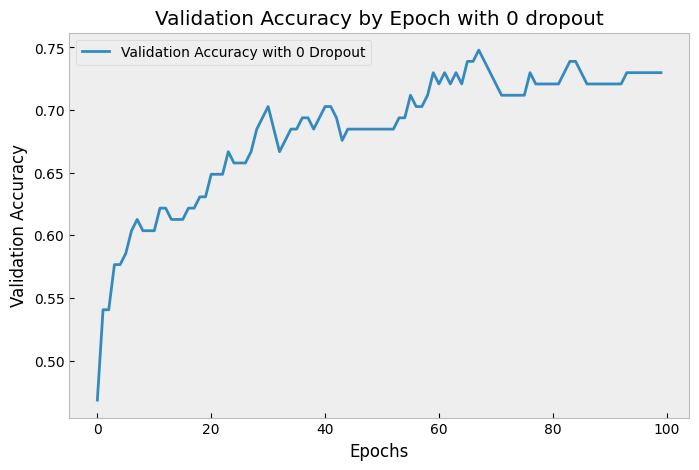

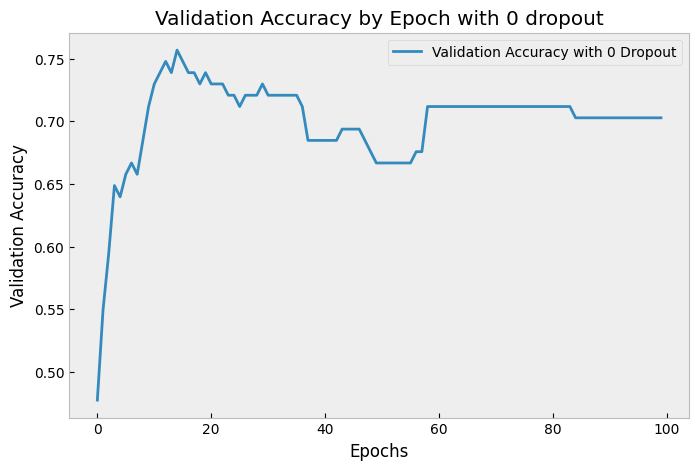

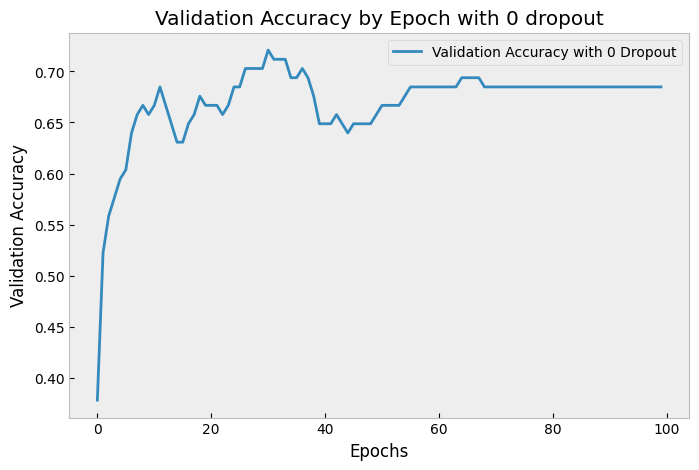

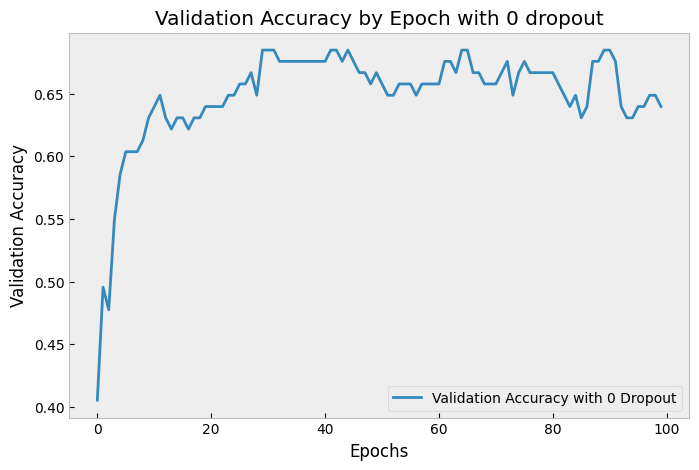

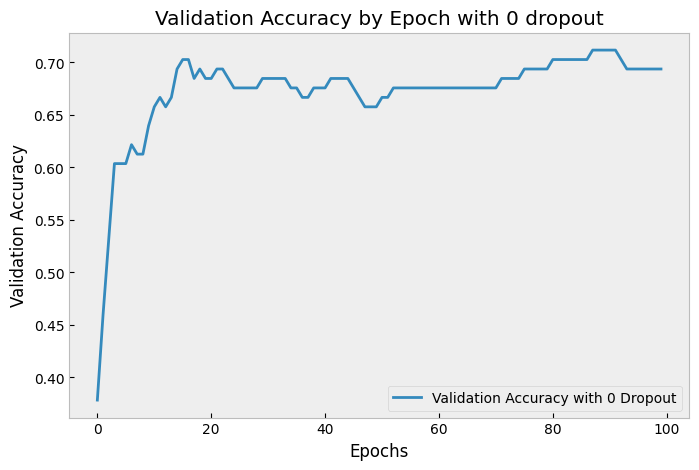

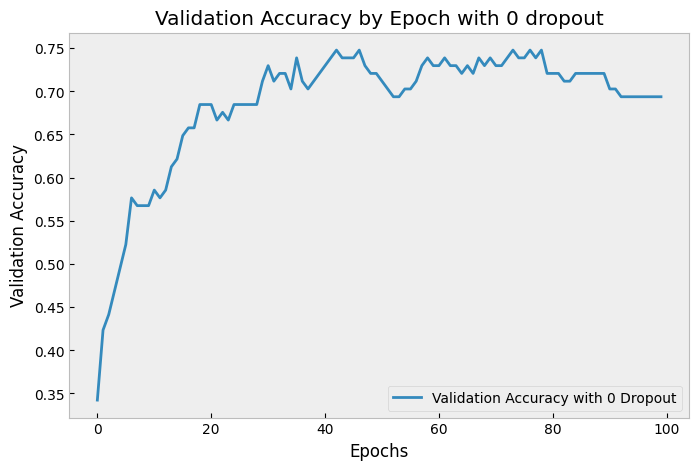

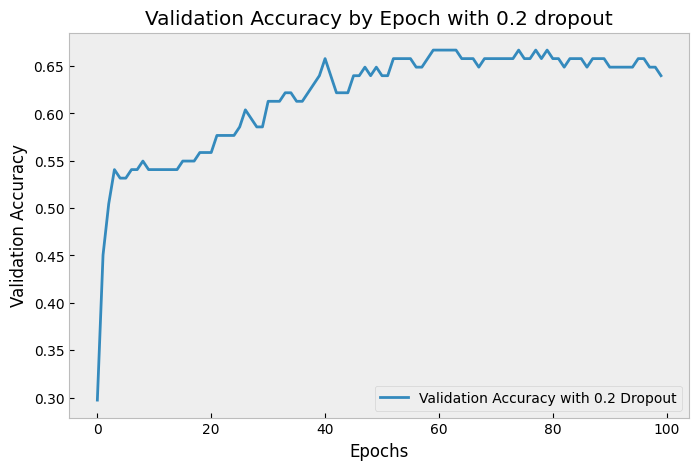

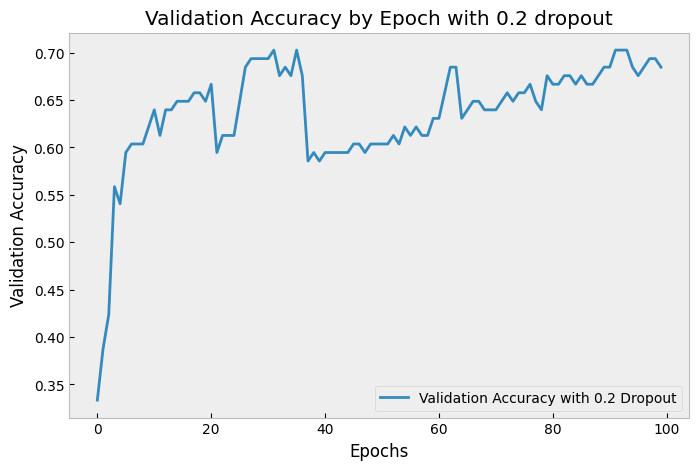

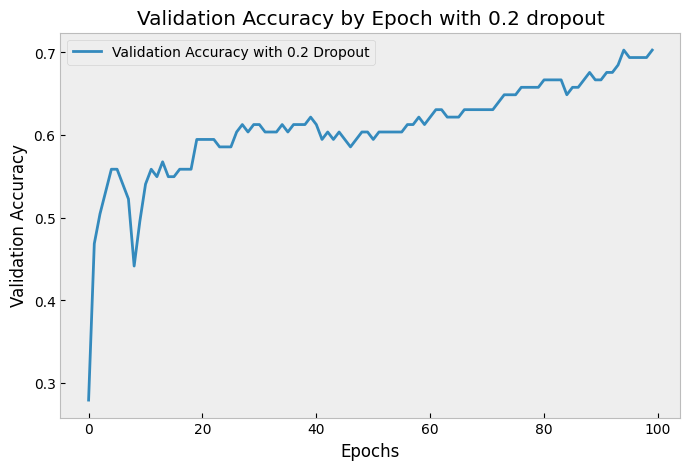

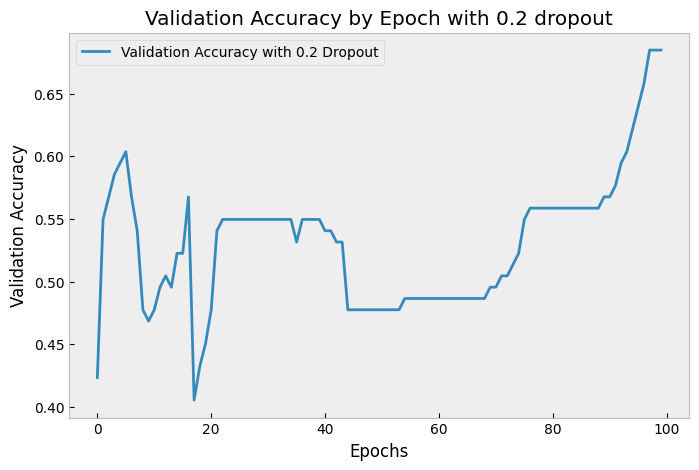

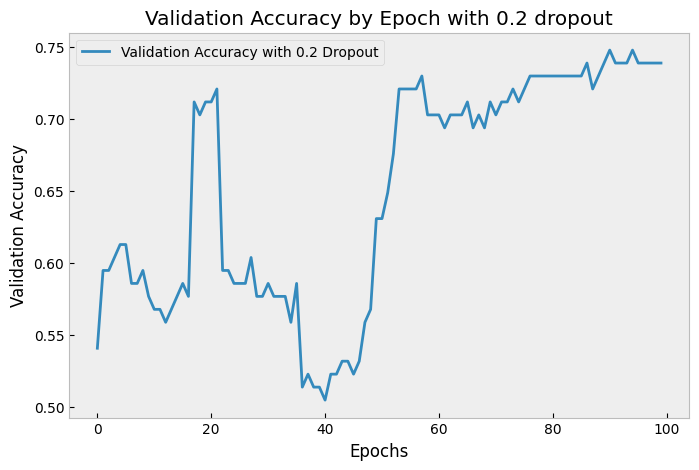

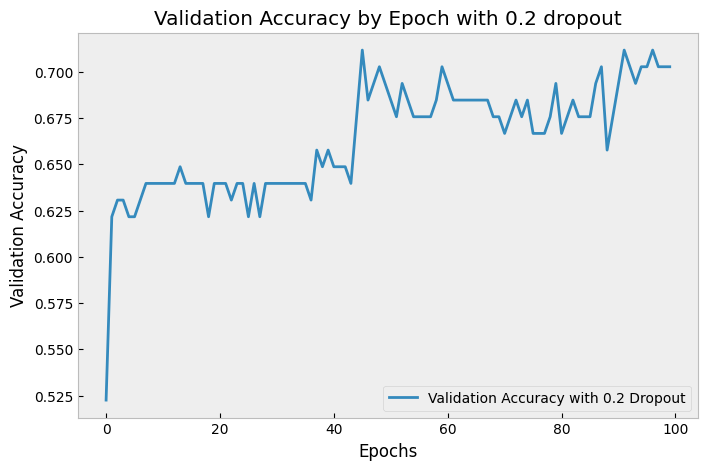

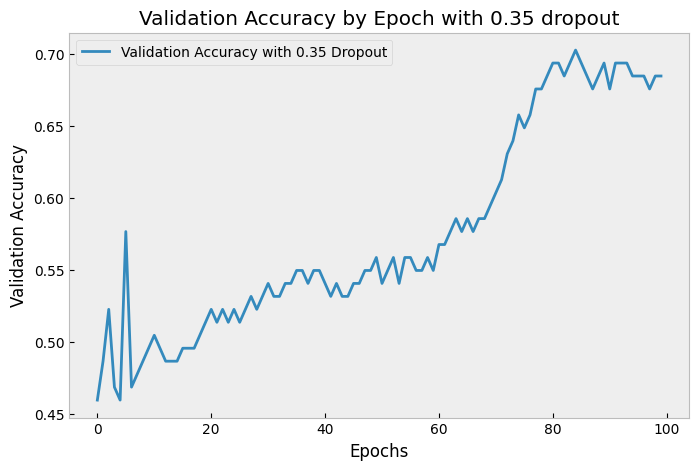

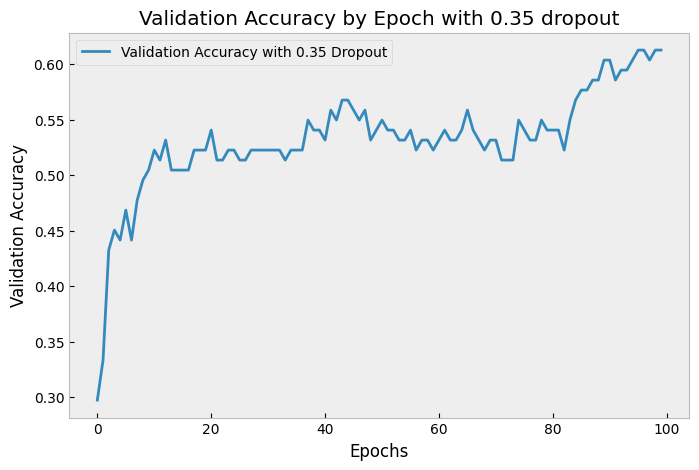

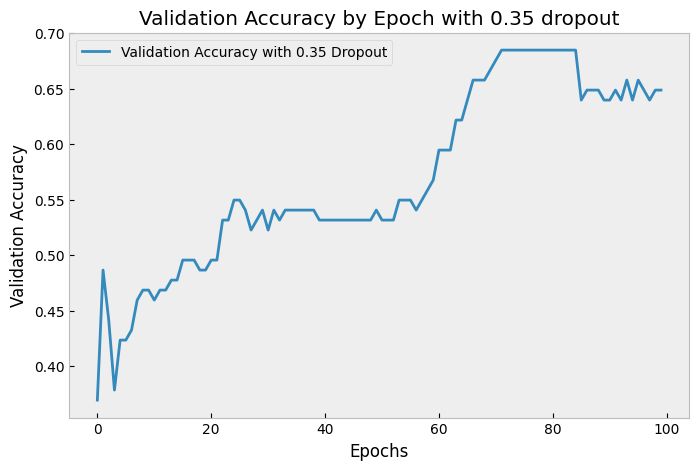

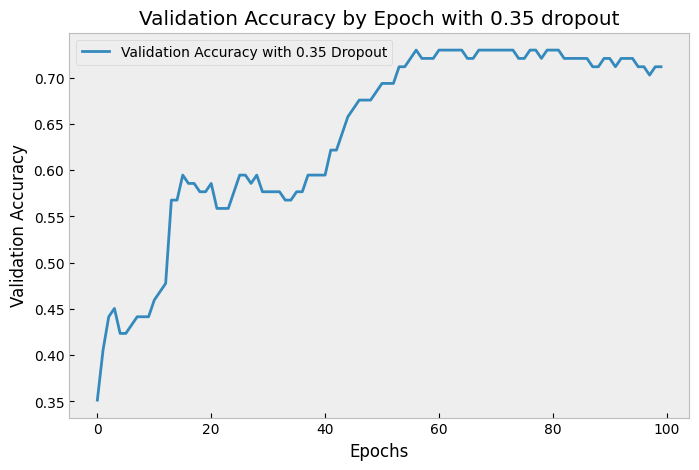

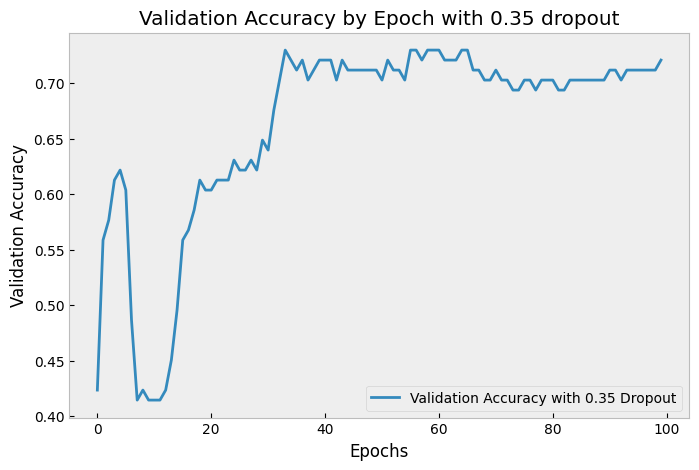

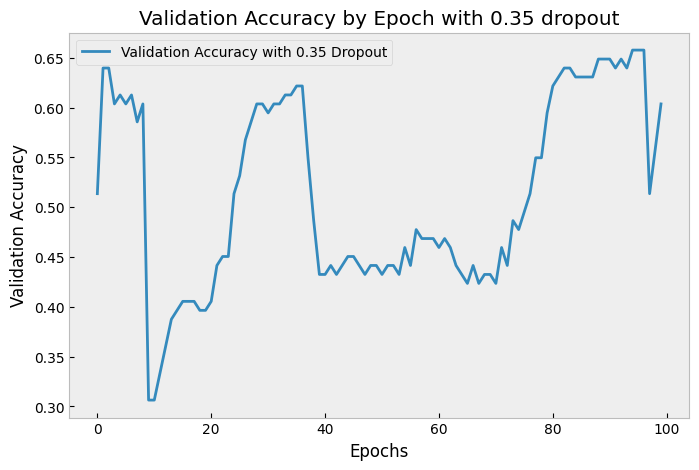

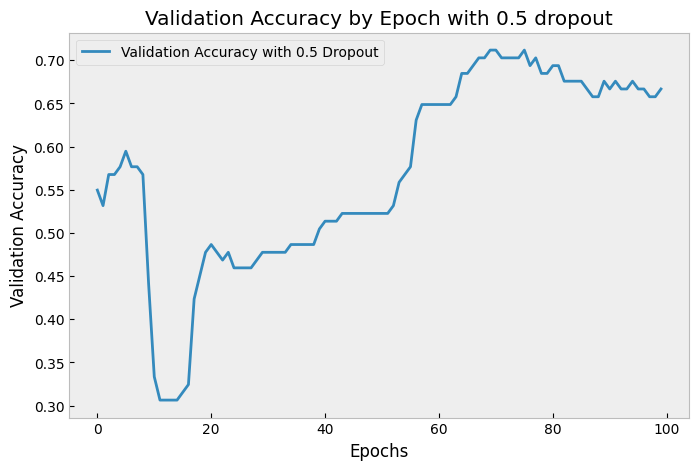

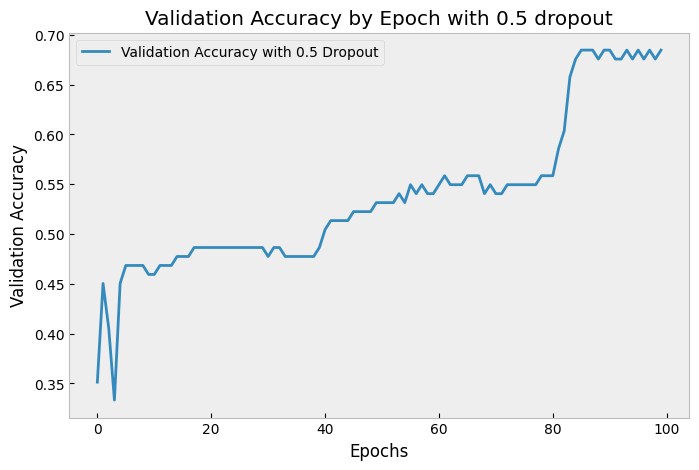

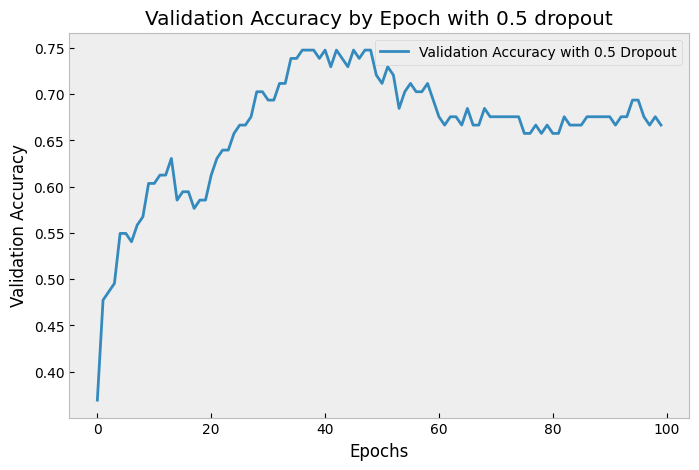

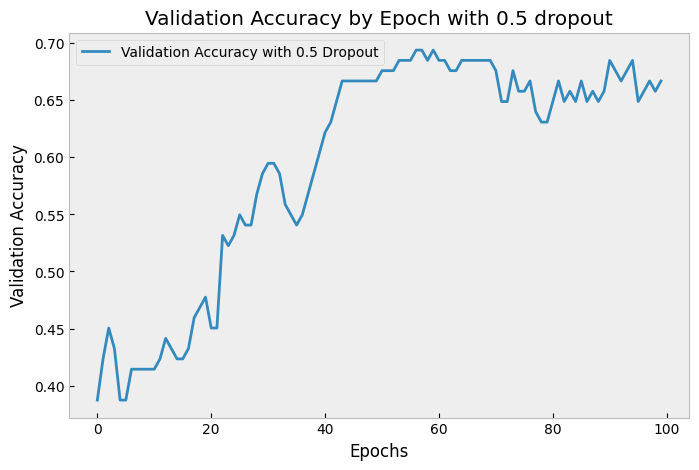

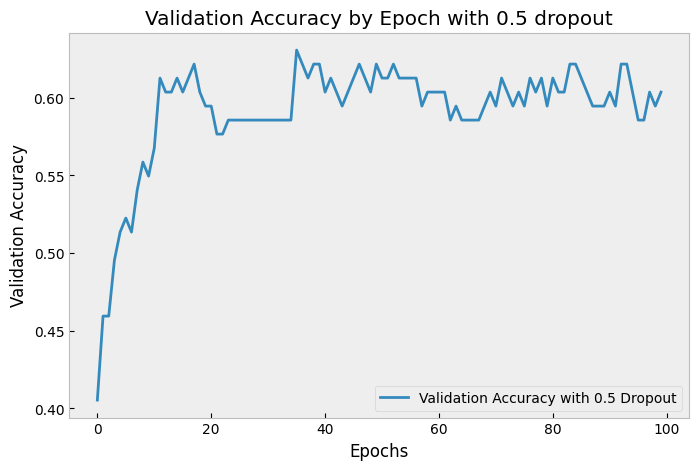

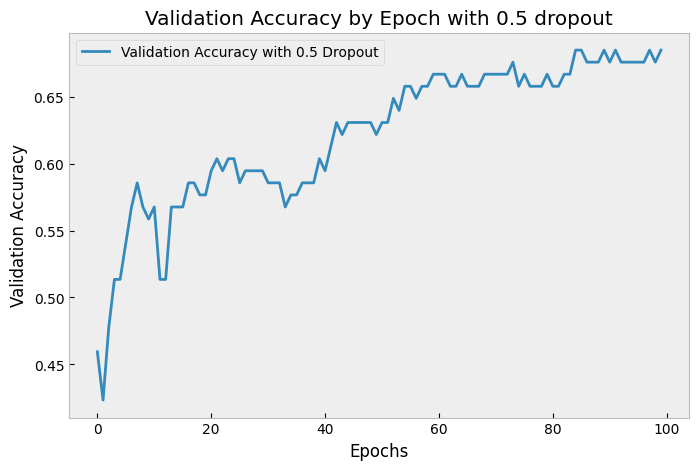

In [54]:
from torchviz import make_dot
import warnings
import matplotlib.pyplot as plt

# plt.style.use("ggplot")
plt.style.use("bmh")




warnings.simplefilter("ignore", UserWarning)

dropout = 0.2
num_epochs = 100



best_val_acc = 0
configs = [False, 0.2, 0.35, 0.5]
number_of_runs = range(1,7)
for config in configs:
    dropout = config
    for run in number_of_runs:
        mr_gcn = MR_GCN([normalize_adjacency(adjacency[relation_id]) for relation_id in adjacency.keys()], 
                identity, num_nodes, 
                feature_matrix_cat.size(1), 
                num_classes=num_classes, 
                dropout=dropout)
        params = list(mr_gcn.parameters())
        criterion = nn.CrossEntropyLoss()
        alpha = 0.01
        optimizer = torch.optim.Adam(params,lr=alpha)
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            mr_gcn.train()
            optimizer.zero_grad()
            
            outputs = mr_gcn()
            loss = criterion(outputs[train_mask], labels[train_mask])
            
            loss.backward()
            for p in mr_gcn.parameters():
                pass
            optimizer.step()
            
            mr_gcn.eval()
        
            make_dot(outputs, params=dict(list(mr_gcn.named_parameters()))).render("mr_gcn_torchviz", format="png")
            with torch.no_grad():
                val_outputs = mr_gcn()
                val_loss = criterion(val_outputs[val_mask], labels[val_mask])
                
                _, predicted = torch.max(val_outputs[val_mask], dim=1)
                correct = (predicted == labels[val_mask]).sum().item()
                tot = val_mask.sum().item()
                if tot:
                    val_acc = correct / tot
                    val_accs.append(val_acc)
                if epoch % 100 == 0 and tot:
                    print(f"epoch: {epoch}\navg loss: {loss}, val_loss: {val_loss} val accuracy: {val_acc}")
    
            # if val_acc > best_val_acc:
            #     mr_gcn.save()
        
        
        with torch.no_grad():
            test_outputs = mr_gcn()
            test_loss = criterion(test_outputs[test_mask], labels[test_mask])
            
            _, predicted = torch.max(test_outputs[test_mask], dim=1)
            correct = (predicted == labels[test_mask]).sum().item()
            tot = test_mask.sum().item()
            if tot:
                test_acc = correct / tot
                test_accs.append((test_acc, config))
    
        print(f"final epoch: {epoch}\navg loss: {loss}, test_loss: {test_loss} test accuracy: {test_acc}")
        dropout_tag = '0' if not dropout else dropout
        plt.figure(figsize=(8, 5))
        plt.plot(range(len(val_accs)), val_accs, label=f"Validation Accuracy with {dropout_tag} Dropout")
        plt.xlabel("Epochs", color='black')
        plt.ylabel("Validation Accuracy", color='black')
        plt.title(f"Validation Accuracy by Epoch with {dropout_tag} dropout", color='black')
        plt.legend(labelcolor='black')
        plt.grid()
        plt.savefig(f"plots/run{run}_validation_accuracy_{dropout_tag}_dropout.png")
        with open('results/results.txt','a') as f:
            f.write(f"Results on the test set with a Modality Encoder Dropout of {dropout_tag} after training for {num_epochs} epochs using Adam with a learning rate of {alpha}: {test_acc}\n\n\n")

In [ ]:
feature_matrix_cat.size(1)

/tmp/ipykernel_643339/1078342199.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dropout', y='test_acc', data=df, palette="Set2")


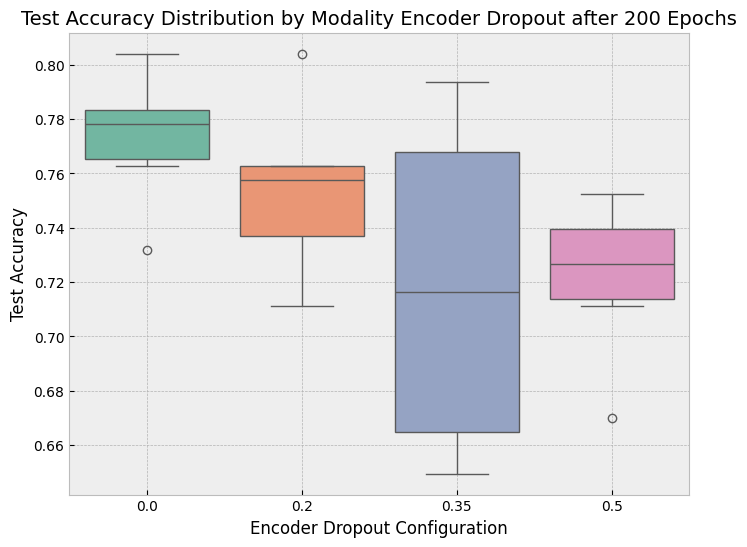

In [57]:
import pandas as pd
import seaborn as sns
test_accs = [
    (0.8041237113402062, 0), (0.7731958762886598, 0), (0.7835051546391752, 0), (0.7319587628865979, 0), (0.7835051546391752, 0), (0.7628865979381443, 0),
    (0.711340206185567, 0.2), (0.7319587628865979, 0.2), (0.7628865979381443, 0.2), (0.7525773195876289, 0.2), (0.8041237113402062, 0.2), (0.7628865979381443, 0.2),
    (0.7525773195876289, 0.35), (0.6597938144329897, 0.35), (0.6804123711340206, 0.35), (0.7938144329896907, 0.35), (0.7731958762886598, 0.35), (0.6494845360824743, 0.35),
    (0.711340206185567, 0.5),  (0.7319587628865979, 0.5),  (0.7422680412371134, 0.5), (0.7216494845360825, 0.5),  (0.6701030927835051, 0.5),  (0.7525773195876289, 0.5)
]

df = pd.DataFrame(test_accs, columns=['test_acc', 'dropout'])
df['dropout'] = df['dropout']

plt.figure(figsize=(8,6))
sns.boxplot(x='dropout', y='test_acc', data=df, palette="Set2")
plt.xlabel("Encoder Dropout Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Test Accuracy Distribution by Modality Encoder Dropout after 200 Epochs", fontsize=14)
plt.grid(True)
plt.savefig("plots/dropout_test_accuracy_boxplot.png")
plt.show()

In [ ]:
4942+391

In [ ]:
loss